<a href="https://colab.research.google.com/github/WyattRoss/csci4170/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [378]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import ttest_rel
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [237]:
data = arff.loadarff('mushrooms.arff')
df = pd.DataFrame(data[0])

# drop columns with only 1 variant. They're redundant
for col in df.columns:
  if len(df[col].unique()) == 1:
    df.drop(col, axis=1, inplace=True)

In [238]:
df_copy = df.copy()
edibility = df_copy.edibility.map({b'e': 0, b'p': 1}).to_numpy()
df_copy.drop("edibility", axis=1, inplace=True) # dropping the label
df_copy.drop("odor", axis=1, inplace=True) # odor is too good an indicator. Results are more interesting without it

encoded_data = pd.get_dummies(df_copy)

testing_data = encoded_data.sample(frac=0.2)
training_data = encoded_data.drop(testing_data.index)

testing_edibility = edibility[testing_data.index]
training_edibility = edibility[training_data.index]

[[784  69]
 [ 75 697]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       853
           1       0.91      0.90      0.91       772

    accuracy                           0.91      1625
   macro avg       0.91      0.91      0.91      1625
weighted avg       0.91      0.91      0.91      1625



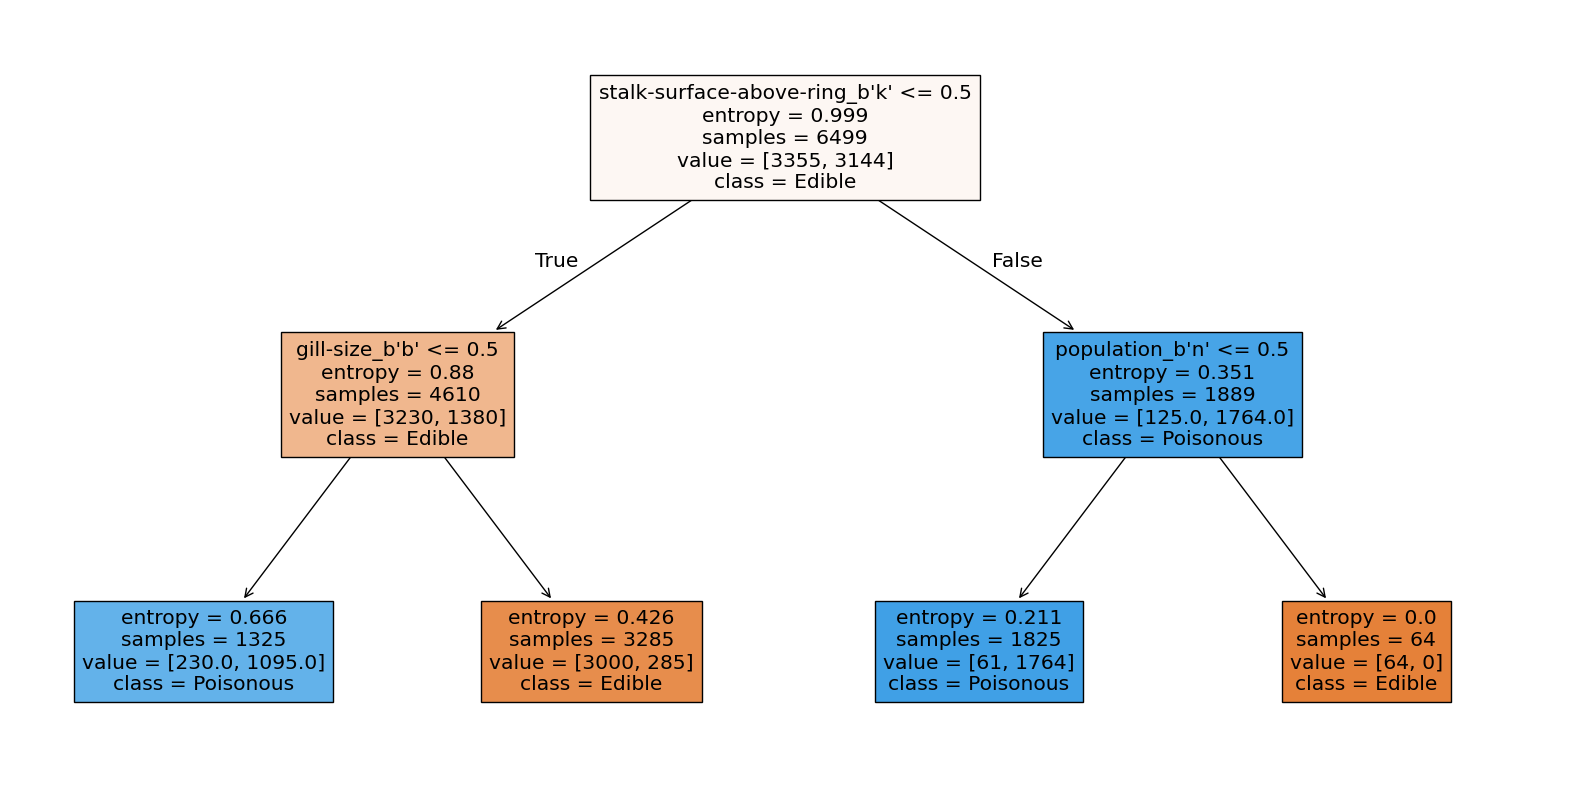

In [341]:
tree_classifier1 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=.3,
    random_state=0
)

tree_classifier1.fit(training_data, training_edibility)
predicted1 = tree_classifier1.predict(testing_data)
print(confusion_matrix(testing_edibility, predicted1))
print(classification_report(testing_edibility, predicted1))
plt.figure(figsize=(20,10))
plot_tree(tree_classifier1, feature_names=encoded_data.columns, class_names=['Edible', 'Poisonous'], filled=True)
plt.show()

[[830  23]
 [ 93 679]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       853
           1       0.97      0.88      0.92       772

    accuracy                           0.93      1625
   macro avg       0.93      0.93      0.93      1625
weighted avg       0.93      0.93      0.93      1625



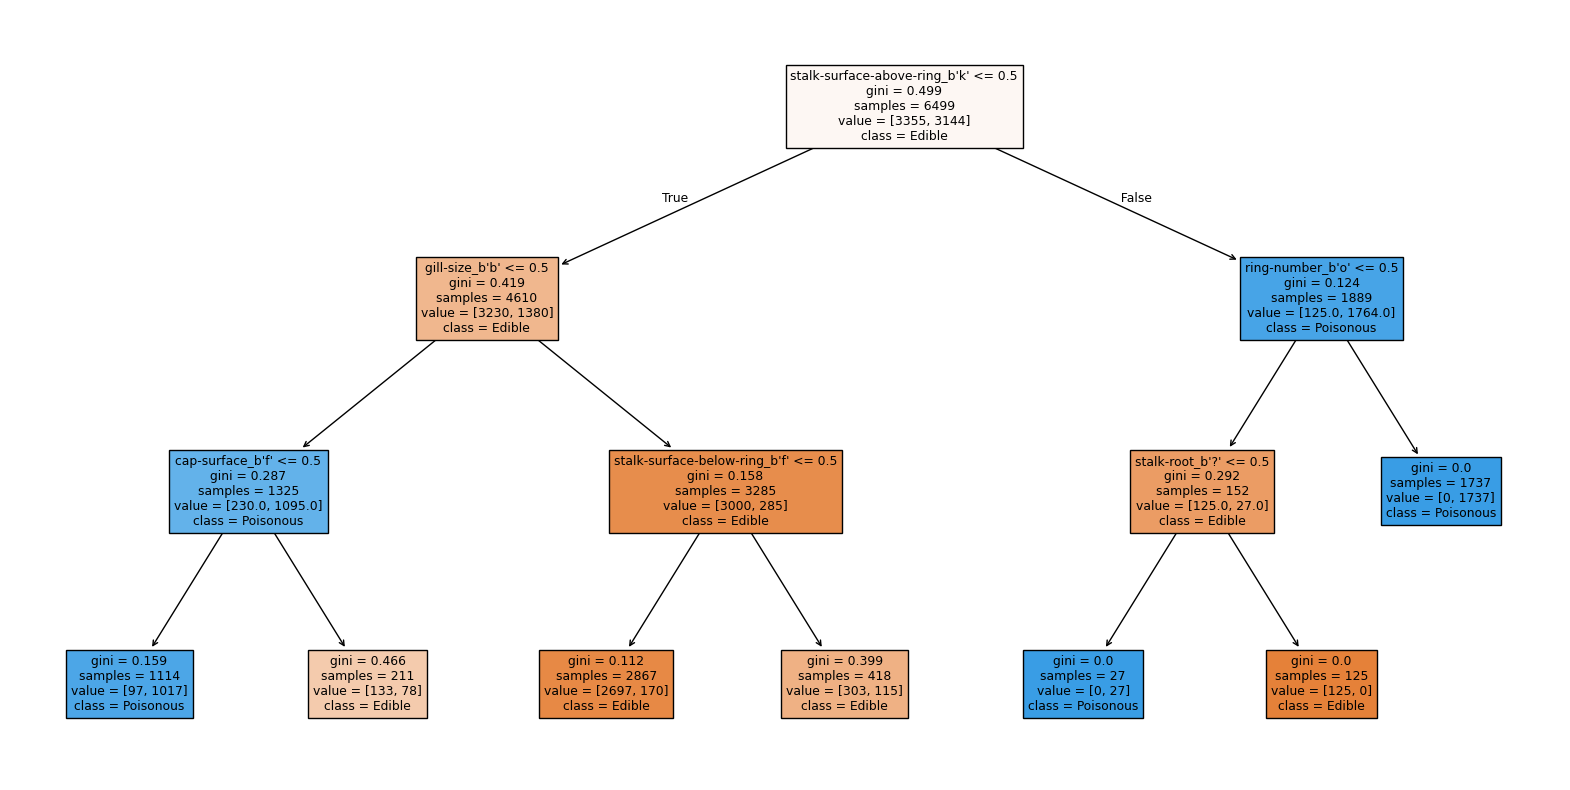

In [343]:
tree_classifier2 = DecisionTreeClassifier( # Higher Max Depth
    criterion="gini",
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=.3,
    random_state=0
)

tree_classifier2.fit(training_data, training_edibility)
predicted2 = tree_classifier2.predict(testing_data)
print(confusion_matrix(testing_edibility, predicted2))
print(classification_report(testing_edibility, predicted2))
plt.figure(figsize=(20,10))
plot_tree(tree_classifier2, feature_names=encoded_data.columns, class_names=['Edible', 'Poisonous'], filled=True)
plt.show()

[[795  58]
 [ 75 697]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       853
           1       0.92      0.90      0.91       772

    accuracy                           0.92      1625
   macro avg       0.92      0.92      0.92      1625
weighted avg       0.92      0.92      0.92      1625



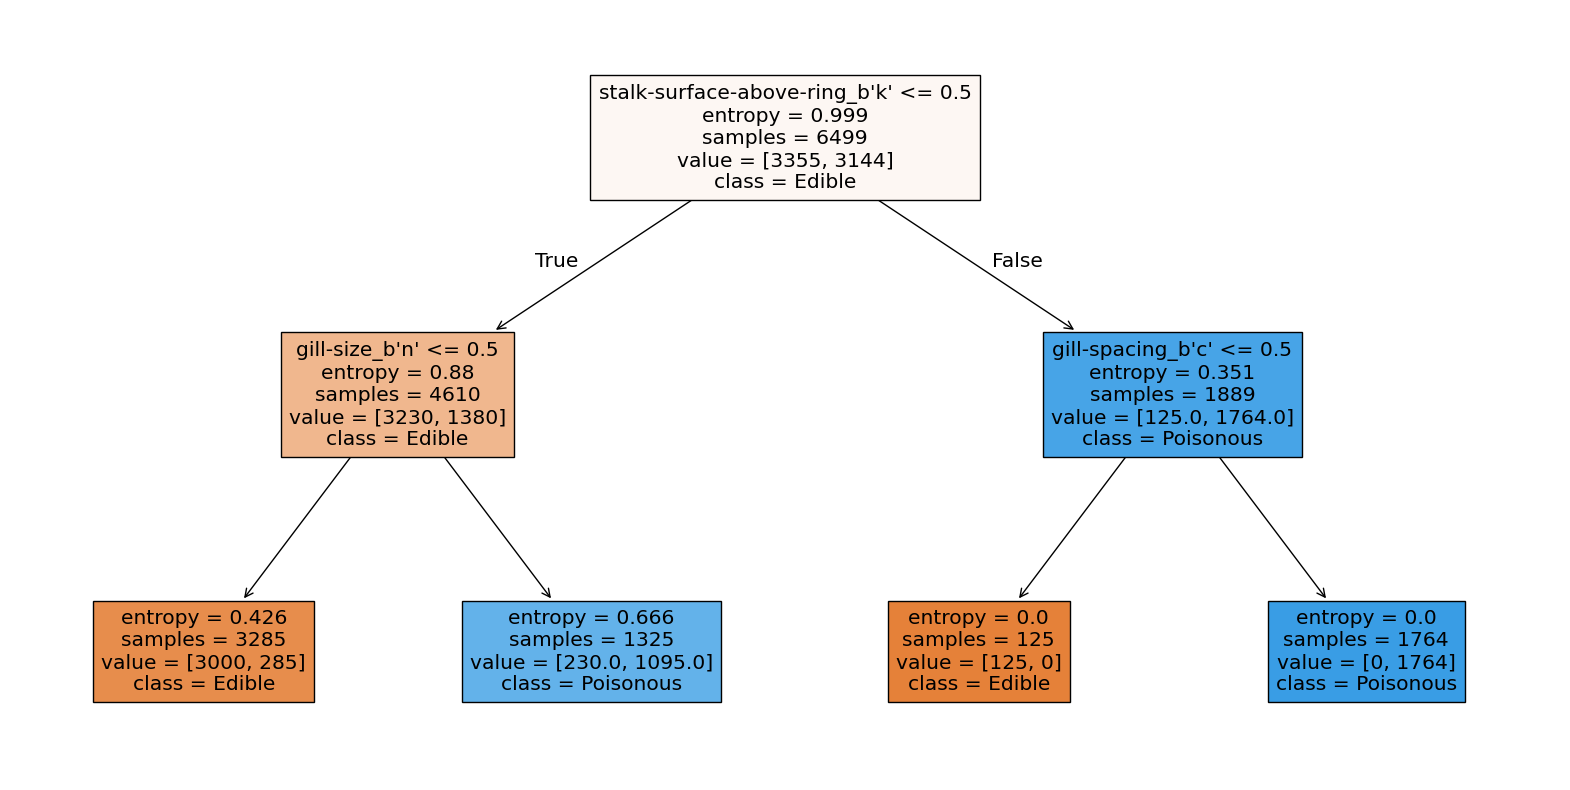

In [344]:
tree_classifier3 = DecisionTreeClassifier( # More feature consideration allowed
    criterion="entropy",
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=.8,
    random_state=0
)

tree_classifier3.fit(training_data, training_edibility)
predicted3 = tree_classifier3.predict(testing_data)
print(confusion_matrix(testing_edibility, predicted3))
print(classification_report(testing_edibility, predicted3))
plt.figure(figsize=(20,10))
plot_tree(tree_classifier3, feature_names=encoded_data.columns, class_names=['Edible', 'Poisonous'], filled=True)
plt.show()

It looks like the factor that governs the shape of the final decision tree is, unsurprisingly, maximum depth. Higher depth allows a more complex tree to form which can better model more complex underlying relationships (to a point).

Maximum features to consider at each split governs complexity of the decisions being made at each node. More features naturally lends itself to more complex models.

In [345]:
def random_replace(data, feature):
  valid_replacements = data[feature].unique()

  generate_replacement = lambda x: np.random.choice([v for v in valid_replacements if v != x[feature]])
  # generate_replacement = lambda x: np.random.choice(valid_replacements)
  # generate_replacement = lambda x: x[feature]

  return generate_replacement

def perturb(data, feature, replacement_function):
  perturbed_data = data.copy()
  perturbed_data[feature] = perturbed_data.apply(replacement_function, axis=1)
  encoded_input = pd.get_dummies(data) # for columns
  encoded_result = pd.get_dummies(perturbed_data)
  encoded_result = encoded_result.reindex(columns=encoded_input.columns, fill_value=0) # fix shape to work with models
  return encoded_result.drop(training_data.index)

def flip_rate(model, data, modified_data, feature):
  predicted = model.predict(data)
  modified_prediction = model.predict(modified_data)
  return np.mean(predicted != modified_prediction)

In [346]:
for feature in df_copy.columns:
  perturbed_data = perturb(df_copy, feature, random_replace(df_copy, feature))
  perturbed_data = perturbed_data.reindex(testing_data.index)
  print(f"Flip rate for {feature}: {flip_rate(tree_classifier2, testing_data, perturbed_data, feature):.2f}")

Flip rate for cap-shape: 0.00
Flip rate for cap-surface: 0.09
Flip rate for cap-color: 0.00
Flip rate for bruises%3F: 0.00
Flip rate for gill-attachment: 0.00
Flip rate for gill-spacing: 0.00
Flip rate for gill-size: 0.50
Flip rate for gill-color: 0.00
Flip rate for stalk-shape: 0.00
Flip rate for stalk-root: 0.01
Flip rate for stalk-surface-above-ring: 0.35
Flip rate for stalk-surface-below-ring: 0.00
Flip rate for stalk-color-above-ring: 0.00
Flip rate for stalk-color-below-ring: 0.00
Flip rate for veil-color: 0.00
Flip rate for ring-number: 0.12
Flip rate for ring-type: 0.00
Flip rate for spore-print-color: 0.00
Flip rate for population: 0.00
Flip rate for habitat: 0.00


For sensitivity analysis I used one-at-a-time perturbation to randomly change eery row along a given feature to a random, different, valid value for that feature. To quantify sensitivity I then measured the rate at which a change in that feature changed the predicted result.

In [349]:
random_forest_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    max_features=.2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=0
)

random_forest_classifier.fit(training_data, training_edibility)
predicted_forest = random_forest_classifier.predict(testing_data)
print(confusion_matrix(testing_edibility, predicted_forest))
print(classification_report(testing_edibility, predicted_forest))

[[835  18]
 [ 23 749]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       853
           1       0.98      0.97      0.97       772

    accuracy                           0.97      1625
   macro avg       0.97      0.97      0.97      1625
weighted avg       0.97      0.97      0.97      1625



In [367]:
weak_learner = DecisionTreeClassifier(
    max_depth=1,
    max_features=.2,
    min_samples_leaf=1)
adaboost_classifier = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=100,
    learning_rate=1.0,
    random_state=0
)

adaboost_classifier.fit(training_data, training_edibility)
adaboost_prediction = adaboost_classifier.predict(testing_data)
print(confusion_matrix(testing_edibility, adaboost_prediction))
print(classification_report(testing_edibility, adaboost_prediction))

[[837  16]
 [ 12 760]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       853
           1       0.98      0.98      0.98       772

    accuracy                           0.98      1625
   macro avg       0.98      0.98      0.98      1625
weighted avg       0.98      0.98      0.98      1625



In [382]:
folds = [5, 10, 15]
np.set_printoptions(precision=3)
for fold in folds:
  skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=0)
  rf_classifier = RandomForestClassifier()
  ada_classifier = AdaBoostClassifier()
  rf_scores = cross_val_score(rf_classifier, encoded_data, edibility, cv=skf)
  ada_scores = cross_val_score(ada_classifier, encoded_data, edibility, cv=skf)

  t_score, p_score = ttest_rel(rf_scores, ada_scores)
  print(f"Fold: {fold}")
  print(f"\tRandom Forest Scores: {rf_scores}")
  print(f"\tRandom Forest Mean Score: {rf_scores.mean()}")
  print(f"\tAdaBoost Scores: {ada_scores}")
  print(f"\tAdaBoost Mean Score: {ada_scores.mean():.3f}")
  print(f"\tT-Score: {t_score:.3f}")
  print(f"\tP-Value: {p_score:.3f}")

Fold: 5
	Random Forest Scores: [1. 1. 1. 1. 1.]
	Random Forest Mean Score: 1.0
	AdaBoost Scores: [0.971 0.977 0.985 0.969 0.967]
	AdaBoost Mean Score: 0.974
	T-Score: 8.155
	P-Value: 0.001
Fold: 10
	Random Forest Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Random Forest Mean Score: 1.0
	AdaBoost Scores: [0.98  0.968 0.972 0.966 0.991 0.982 0.967 0.975 0.975 0.979]
	AdaBoost Mean Score: 0.976
	T-Score: 9.731
	P-Value: 0.000
Fold: 15
	Random Forest Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	Random Forest Mean Score: 1.0
	AdaBoost Scores: [0.967 0.976 0.965 0.982 0.978 0.969 0.961 0.969 0.989 0.957 0.969 0.972
 0.983 0.961 0.982]
	AdaBoost Mean Score: 0.972
	T-Score: 11.729
	P-Value: 0.000


The default ensemble learning classifiers had a really easy time on the data, so it's hard to make any sweeping generalizations about the difference between the models especially with regard to their performance after cross-verification. *In general*, it seems like the ADABoost classifier works at least as well as the random forest based classifier in this workload whether evaluated by recall, precision or f1-score. But performance is so uniformly good (and my attempts to sandbag that performace so uniformly ineffective) that it's really hard to say.

T-Scores show that for the models with whatever the default hyperparameters are (as used in cross-validation testing), the random forest classifier outperforms the ADABoost classifier. Surprisingly (to me at least), the P-value indicates that this is a statistically significant result. I wouldn't have guessed that just based on the results as they were before performing the cross-verification testing and T test.

In [377]:
test_fold = 5
skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=0)


for i, (train_index, test_index) in enumerate(skf.split(encoded_data, edibility)):
  data_train, data_test = encoded_data.iloc[train_index], encoded_data.iloc[test_index]
  label_train, label_test = edibility[train_index], edibility[test_index]

  tree_classifier1.fit(data_train, label_train)

  tree_predict = tree_classifier1.predict(data_test)


print(confusion_matrix(label_test, tree_predict))


[[248  32]
 [ 29 232]]
